**Note 1:** Thanks to Karen Simonyan & Andrew Zisserman for providing us with the VGG-19

**Note 2:** This code bring me 7/2700 place in Fast, Furious & Insured competition on https://www.hackerearth.com 
But I took this place by the analytical feeling, without any ML or DL model. NN-fitting was stopped on the 30 of 50 epoch, by disconnection, so all weights are lost. I got a little upset, cause I had spent almost all GPU-time provided by kaggle platform before! I really felt the 1st place :)

**Note 3:** Kurt would have loved python

In [1]:
# I use two cells for getting libs, and its really bad manners, but plotly has failed after using tf! so we'll have get it later

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from PIL import Image
import plotly
import plotly.graph_objs as go
import albumentations as A

from tqdm import tqdm

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# putting our data in
tr = pd.read_csv('../input/fast-furious-and-insured/Fast_Furious_Insured/train.csv')
tt = pd.read_csv('../input/fast-furious-and-insured/Fast_Furious_Insured/test.csv')

In [17]:
# checking missed values
def check_missed_values(df):
    
    k = 0
    ss = df.columns.to_list()
    for i in ss:
        
        cou = len(df[df[i].isna()][i])
        if cou == 0:
            k += 1
        else:
            print(i + ' feature have ' + str(cou) + ' missed values')
            
    if k == len(ss):
        print('This frame have no missed values \(•◡•)/')
            
check_missed_values(tt)

This frame have no missed values \(•◡•)/


In [18]:
check_missed_values(tr)

Cost_of_vehicle feature have 89 missed values
Min_coverage feature have 89 missed values
Max_coverage feature have 89 missed values
Amount feature have 11 missed values


In [5]:
def check_companies(data):
    
    print('There are ' + str(data.Insurance_company.nunique()) + ' different insurance companies')
    print('So its:\n', sorted(data.Insurance_company.unique()))

check_companies(tr)    

There are 11 different insurance companies
So its:
 ['A', 'AA', 'AC', 'B', 'BB', 'BC', 'BQ', 'C', 'DA', 'O', 'RE']


In [6]:
check_companies(tt)

There are 11 different insurance companies
So its:
 ['A', 'AA', 'AC', 'B', 'BB', 'BC', 'BQ', 'C', 'DA', 'O', 'RE']


In [15]:
# some function showing us a pie chart
def viz_percents(x, after=False):
    
    state = 'Before'
    if after:
        state = 'After'

    vc_series = x.Condition.value_counts()
    percent = str(round(100 * vc_series[0] / (vc_series[0] + vc_series[1])))
    vc_series.index = ['damaged car', 'not damaged']
    
    fig = go.Figure()
    fig.add_trace(go.Pie(
        values=vc_series,
        labels=vc_series.index,
        sort=False,
        pull=0.03,
        hole=0.8
    ))
    fig.update_layout(
        title='Ratio diagram',
        title_x = 0.45,
        annotations=[dict(
            text='Only '+ percent +'% of given<br>cars are not<br>damaged',
            x=0.5,
            y=0.48,
            font_size=25,
            showarrow=False)])
    
    return fig.show()

In [16]:
viz_percents(tr)

In [9]:
# the 2nd ceil with tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental import preprocessing
from keras import backend

In [10]:
# we need to predict two labels
# so evaluation metric contains two metrics at once 
# Condition label evaluated by f1_score, and Amount one estimated by r2_score 
# max_score is 100, and it includes 50 * (f1_score + r_2score)
# so far we take r2 only

def R2(y_true, y_pred):
    SS_res =  backend.sum(backend.square(y_true - y_pred)) 
    SS_tot = backend.sum(backend.square(y_true - backend.mean(y_true))) 
    return 100 * (1 - SS_res / (SS_tot + backend.epsilon()))

In [11]:
# let's explore our numerical features
num_train = tr[['Cost_of_vehicle', 'Min_coverage', 'Max_coverage', 'Amount', 'Condition']]

<AxesSubplot:>

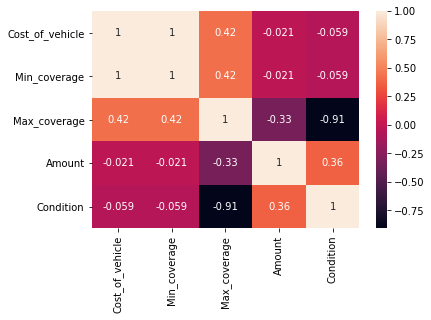

In [12]:
# at least one feature should be dropped
sns.heatmap(num_train.corr(), annot=True)
# but...

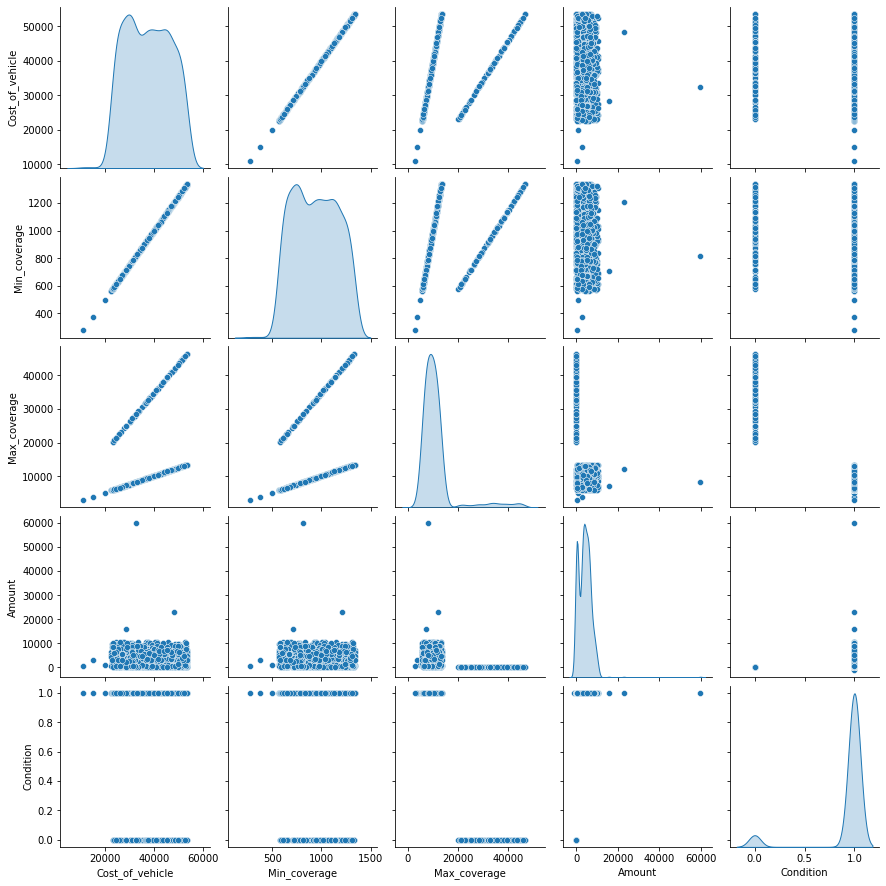

In [13]:
# now, having interesting Max_coverage feature
sns.pairplot(num_train, diag_kind='kde')

<AxesSubplot:>

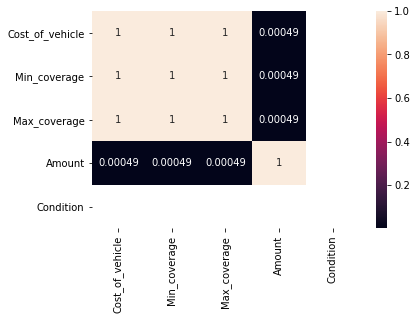

In [14]:
# let's check it for true condiion
sns.heatmap(num_train[num_train.Condition > 0].corr(), annot=True)

In [16]:
# by the way! Now, we know, that false Condition provides us with 0 Amount value
num_train[['Condition', 'Amount']][num_train.Condition < 1].Amount.sum()

0.0

In [20]:
# but we have some missed Amount values :( 
print(num_train[['Condition', 'Amount']][num_train.Condition > 0].Amount.min())
num_train[num_train.Amount == -999]

-999.0


,Cost_of_vehicle,Min_coverage,Max_coverage,Amount,Condition
641,NaN,NaN,NaN,-999.0,1


<AxesSubplot:xlabel='Amount', ylabel='Count'>

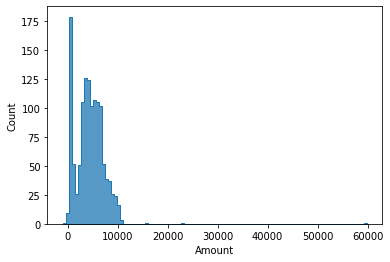

In [31]:
# let's look at the Amount distribution
sns.histplot(num_train[num_train.Condition > 0].Amount, bins=100, element="step")

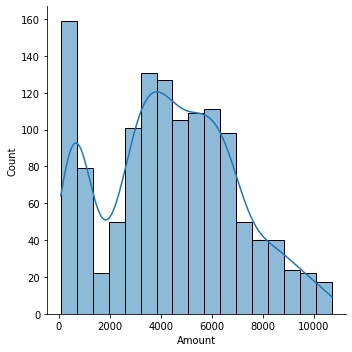

In [32]:
# again on a different scale 
sns.displot(num_train[(num_train.Amount > 0) & (num_train.Amount < 15000)].Amount, kde=True)

In [33]:
# using this feature gives to us information about condition
tr['Good_feature'] = round(1 - tr.Max_coverage/tr.Cost_of_vehicle)
tr[(tr.Amount >= 0) & (tr.Amount < 15000)]

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount,Good_feature
0,img_4513976.jpg,BQ,41500.0,1037.5,2026-12-03,36142.68,0,0.0,0.0
1,img_7764995.jpg,BQ,50700.0,1267.5,2025-07-10,12753.00,1,6194.0,1.0
2,img_451308.jpg,A,49500.0,1237.5,2022-08-11,43102.68,0,0.0,0.0
3,img_7768372.jpg,A,33500.0,837.5,2022-08-02,8453.00,1,7699.0,1.0
4,img_7765274.jpg,AC,27600.0,690.0,2026-05-01,6978.00,1,8849.0,1.0
...,...,...,...,...,...,...,...,...,...
1393,img_4535755.jpg,AC,51500.0,1287.5,2022-01-07,12953.00,1,4058.0,1.0
1394,img_4637237.jpg,DA,52300.0,1307.5,2025-02-17,13153.00,1,4565.0,1.0
1395,img_4637000.jpg,BQ,41500.0,1037.5,2023-12-30,10453.00,1,3363.0,1.0
1396,img_4637503.jpg,AA,31400.0,785.0,2022-11-25,7928.00,1,5336.0,1.0


In [34]:
# drop lines with null values
tr = tr[tr.Max_coverage.isnull() == False]

# checking for matching

if (tr.Condition - tr.Good_feature).sum() == 0:
    print('Condition feature is exactly the same as the Good one!')

Condition feature is exactly the same as the Good one!


In [74]:
# at first glance datasets are pretty similar
pd.merge(tr.Cost_of_vehicle.describe().to_frame().reset_index(),
         tt.Cost_of_vehicle.describe().to_frame().reset_index(),
         on='index',
         suffixes=("_train", "_test"))

,index,Cost_of_vehicle_train,Cost_of_vehicle_test
0,count,1310.000000,600.000000
1,mean,37454.274809,38175.500000
2,std,8921.428143,9181.904052
3,min,11100.000000,20000.000000
4,25%,29800.000000,30600.000000
5,50%,37300.000000,37650.000000
6,75%,45175.000000,46000.000000
7,max,53500.000000,79200.000000


In [76]:
# there are 2-3 outliers
tr[tr.Amount > 15000]

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount,Good_feature
786,img_7764865.jpg,BQ,48200.0,1205.0,2023-01-15,12128.0,1,23000.0,1.0
955,img_4635923.jpg,B,28400.0,710.0,2024-10-26,7178.0,1,15836.0,1.0
1324,img_7767995.jpg,AA,32500.0,812.5,2022-03-03,8203.0,1,59844.0,1.0


In [77]:
tr = tr[tr.Condition > 0]
tr = tr[(tr.Amount > 0) & (tr.Amount < 15000)]

In [78]:
check_missed_values(tr)

This frame have no missed values \(•◡•)/


In [109]:
def compare_two_pictures(st, nd):
    
    data_1 = Image.open('../input/fast-furious-and-insured/Fast_Furious_Insured/trainImages/' + tr.Image_path[st])
    data_2 = Image.open('../input/fast-furious-and-insured/Fast_Furious_Insured/trainImages/' + tr.Image_path[nd])

    fig, axes = plt.subplots(1, 2)

    axes[0].imshow(data_1)
    axes[0].set_title('Cost of vehicle: ' + str(tr.Cost_of_vehicle[st]) + '\nAmount: ' + str(tr.Amount[st]))

    axes[1].imshow(data_2)
    axes[1].set_title('Cost of vehicle: ' + str(tr.Cost_of_vehicle[nd]) + '\nAmount: ' + str(tr.Amount[nd]))

    fig.set_figwidth(12)   
    fig.set_figheight(6) 
       
    return plt.show()
    

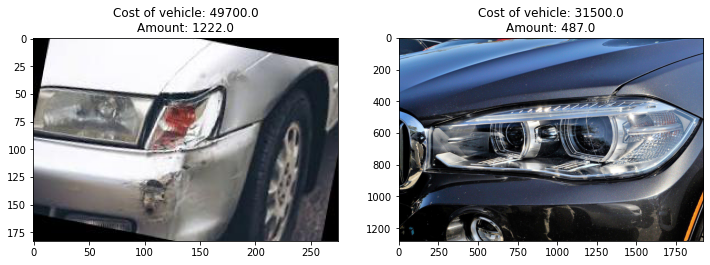

In [110]:
# obviously, given data have a lot of wrong information, e. g. it includes photos of photos, people, and even doodles, etc. 
compare_two_pictures(1384, 1388)
# can you believe that BMW is cheaper than this carriage?
# if even the car, we're seeing it on left image, a collectible one and got beaten... why is amount of insurance so low with respect to unbeaten BMW ?!
# and this is not the only case

In [111]:
# getting Condition feature, and it means, we already have 50% of max_score
tt['Condition'] = round(1 - tt.Max_coverage / tt.Cost_of_vehicle).apply(int)

In [112]:
# making some dataset for working with Amount feature
tt_with_true_condition = tt[tt.Condition > 0]

In [113]:
# write some function to get test data, or train set with augmentation 
def get_augm(data, IMG_SIZE=(224, 224)):
         
    assert data == 'test' or data == 'train', 'Wrong parameter given. Use "train" or "test"'
        
    def pixels_from_path(file_path):
    
        im = Image.open('../input/fast-furious-and-insured/Fast_Furious_Insured/'+ data + 'Images/' + file_path)
        im = im.resize(IMG_SIZE)
        
        return np.array(im)
    
    frame = tr if data == 'train' else tt_with_true_condition
    image_paths = frame.Image_path.to_list()
          
    some_x, some_y = [], []
    
    for car in tqdm(image_paths, desc="Progress"):        
        
        pict = pixels_from_path(car)
        some_x.append(pict)
        if data == 'train':
            ys = frame[frame.Image_path == car].Amount
            some_y.append(ys)
        transform = A.Compose([
            A.RandomCrop(width=150, height=150),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
                              ])
        if data == 'train':
            for _ in range(4):
                some_x.append(np.array(Image.fromarray(np.uint8(transform(image=pict)['image'] * 255)).resize(IMG_SIZE)))
                some_y.append(ys)    
    
    features = np.array(some_x)
    print('Completed!')
    if data == 'train':         
        labels = np.array(some_y)
        return features, labels
    else:
        return features

In [114]:
# getting train features and labels
x_train, y_train = get_augm('train')

Progress: 100%|██████████| 1201/1201 [00:32<00:00, 37.34it/s]


Completed!


In [136]:
# we'll use 50 epochs for fitting
epochs = 50
# so 20 percents of train data we require for validation
val_split = 0.2
# number of images used in training
int(x_train.shape[0] * val_split)

1201

In [137]:
pre_batch = round((x_train.shape[0] * (1 - val_split)) / epochs - 1)
print('good batch size is less or equal to ' + str(pre_batch))

good batch size is less or equal to 95


In [134]:
batch_size = 0
for k in [2**i for i in range(10)]:
    if k < pre_batch:
        batch_size = k
    else:
        break
print("we'll use batch_size = " + str(batch_size))

we'll use batch_size = 64


In [ ]:
normalizer = preprocessing.Normalization()

In [ ]:
# this model is similar with VGG-19, but it used for regression and it has lesser Dense layers (2048 instead of 4096) than VGG-19 
model = Sequential([
    normalizer,
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
    Flatten(),
    Dropout(0.3),
    Dense(2048, activation='relu'),
    Dense(2048, activation='relu'),
    Dense(1, activation='linear')
])

In [ ]:
# model.summary()

In [ ]:
# taking mse as loss because the best value of it is zero, but the best r2*100 value is 100
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=R2)

In [ ]:
try:
    history = model.fit(x_train, y_train, validation_split = val_split, batch_size=batch_size, epochs=epochs)
except KeyboardInterrupt:
    model.save('./')

In [ ]:
# showing us last epochs
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(10)

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 15000000])
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
# visualize history
plot_loss(history)

In [ ]:
# transform images to numbers
x_test = get_augm('test')

In [ ]:
# calculating a mean of 5 predictions as label for more nonrandomly estimation
y = (model.predict(x_test) + model.predict(x_test) + model.predict(x_test) + model.predict(x_test) + model.predict(x_test)) / 5

In [ ]:
# preds = []
# for i in y:
#     preds.append(sum([i[k]*(k / 10) for k in range(11)]))

In [ ]:
tt_with_true_condition['Amount'] = y

In [ ]:
assert (tt_with_true_condition['Amount'].max() - tt_with_true_condition['Amount'].min()) > 100, 'Seems, your model returns one number for all cases'

In [ ]:
tt['Amount'] = pd.concat([tt[tt.Condition < 1].Condition, tt_with_true_condition.Amount]).sort_index()

In [ ]:
ans = tt[['Condition', 'Amount']]
ans.index = tt.Image_path

In [ ]:
ans

In [ ]:
ans.to_csv('sample_submission.csv')